Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [4]:
import zipfile

In [5]:
#Unzipping compressed Input File
with zipfile.ZipFile('CNN_assignment.zip','r') as f:
    f.extractall('input/')

### Importing all the important libraries

In [6]:
!pip install tensorflow

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("input/Skin cancer/Train/")
data_dir_test = pathlib.Path('input/Skin cancer/Test/')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

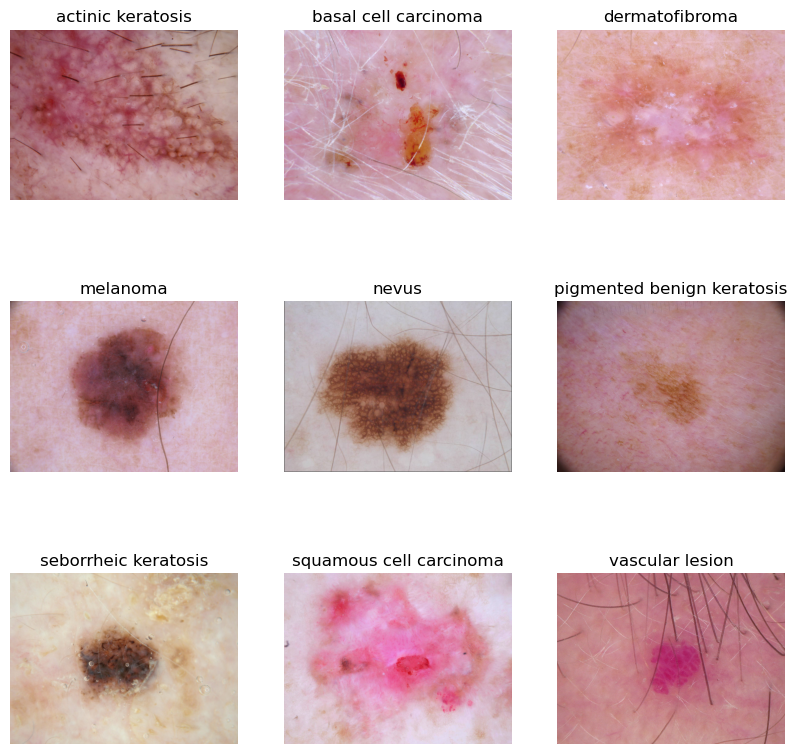

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))

for lesion_type in range(9):
    class_path = glob.glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### model 1
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255), #normalisation
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compiling the model

Justification for optimizer choice.
While stochastic gradient descent ('sgd') is known to generalise better than adaptive moment estimation ('adam'), we have opted to use adam due to time constraints as it has a tendency to converge faster. The project pipeline states that the number of epochs to use be 20, so this makes sense considering the specific circumstances of this project. Ideally, the use of an ensemble approach applying both optimizers may be a better choice, but is outside the constraints of this project.

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 43s 777ms/step - loss: 1.5997 - accuracy: 0.4470 - val_loss: 1.5559 - val_accuracy: 0.4609
Epoch 2/20
56/56 [==============================] - 41s 740ms/step - loss: 1.4348 - accuracy: 0.5073 - val_loss: 1.4336 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 42s 746ms/step - loss: 1.3951 - accuracy: 0.5045 - val_loss: 1.5993 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 45s 806ms/step - loss: 1.3777 - accuracy: 0.5240 - val_loss: 1.4080 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 44s 779ms/step - loss: 1.2797 - accuracy: 0.5463 - val_loss: 1.3883 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 47s 831ms/step - loss: 1.2261 - accuracy: 0.5575 - val_loss: 1.4672 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 43s 762ms/step - loss: 1.1741 - accuracy: 0.5798 - val_loss: 1.4197 - val_accuracy: 0.5235

### Visualizing training results

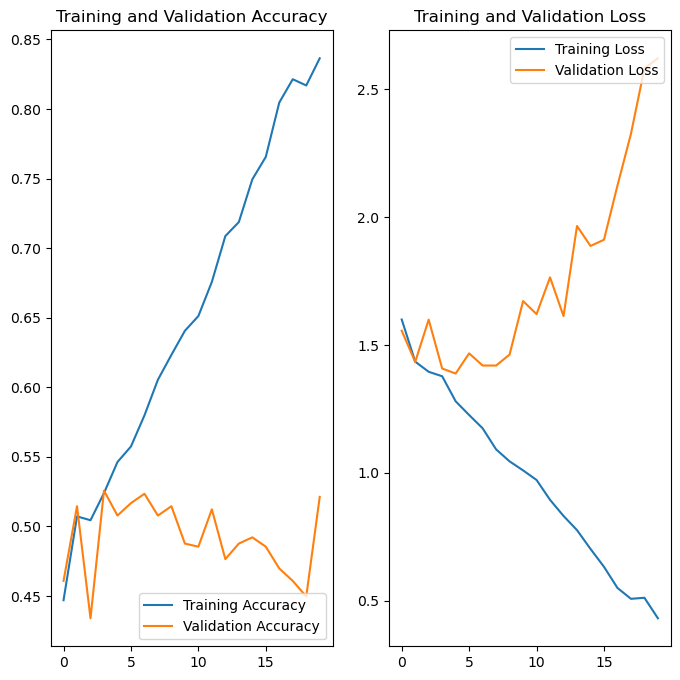

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

### Data Augmentation

we have opted for a mixture of RandomFlip, RandomRotation and RandomContrast and RandomBrightness.

In [89]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3)
])

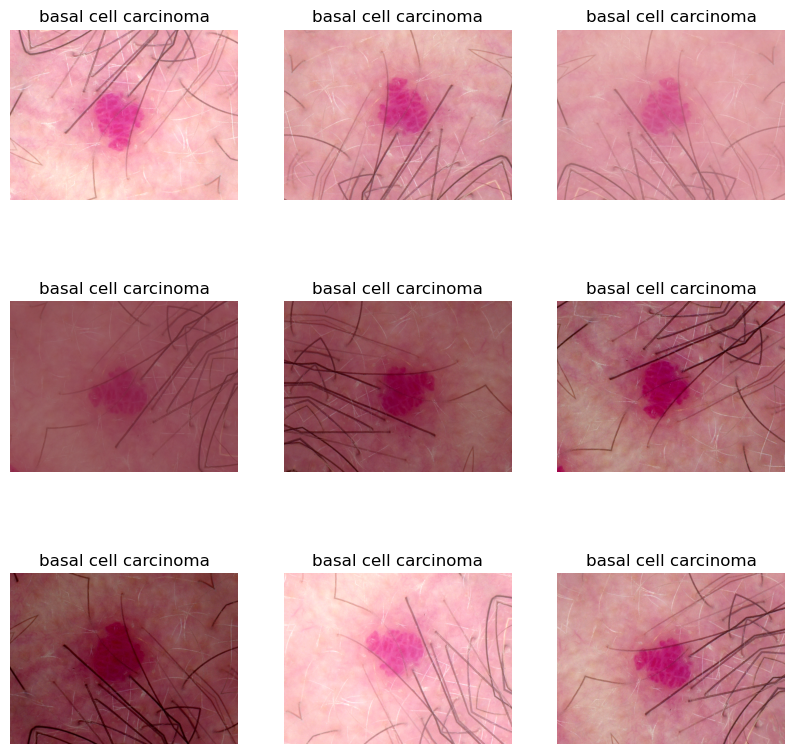

In [90]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(class_names[labels[1]])
        plt.axis("off")


### Modelling, compiling and training the model after data augmentation


In [27]:
## Using Dropout layer as there is an evidence of overfitting

dropout_conv=0.05
dropout_dense=0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])

In [28]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 60s 1s/step - loss: 2.0552 - accuracy: 0.2204 - val_loss: 1.9798 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 54s 971ms/step - loss: 1.8284 - accuracy: 0.3460 - val_loss: 1.7798 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 57s 1s/step - loss: 1.7124 - accuracy: 0.3901 - val_loss: 1.5969 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 56s 1000ms/step - loss: 1.6594 - accuracy: 0.4135 - val_loss: 1.6330 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 59s 1s/step - loss: 1.6499 - accuracy: 0.3996 - val_loss: 1.5237 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 55s 990ms/step - loss: 1.5981 - accuracy: 0.4235 - val_loss: 1.5765 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 55s 981ms/step - loss: 1.5574 - accuracy: 0.4397 - val_loss: 1.5024 - val_accuracy: 0.4877
Epoch 8

### Visualizing the results

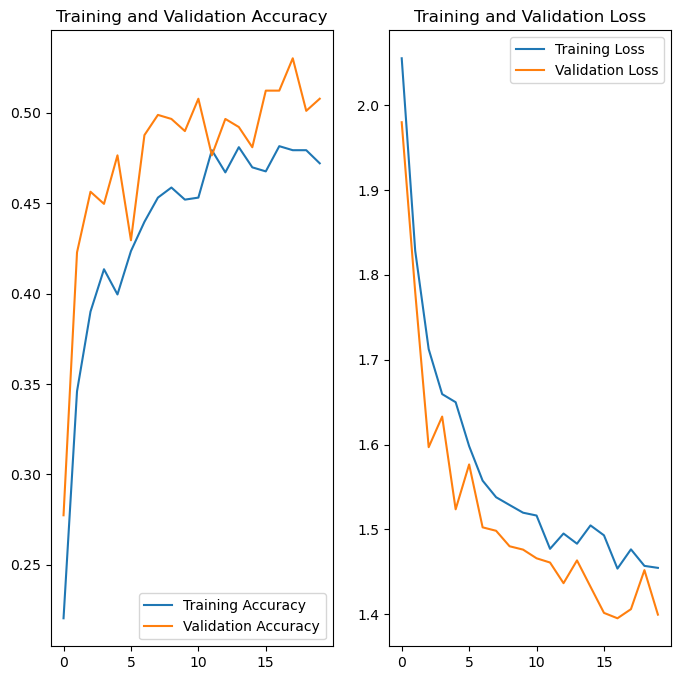

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As can be seen, the model with augmentation and dropouts does not perform better on the training data, actually performing significantly worse. Hence we can say model is now underfitting.

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
count= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                           if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(data_dir_train)
                if os.path.isdir(os.path.join(data_dir_train, name))]

#return dataframe with image count and class.
count =  pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [39]:
count

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


C:\Users\pooja.sonkar\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pooja.sonkar\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pooja.sonkar\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='No. of Image', ylabel='Class'>

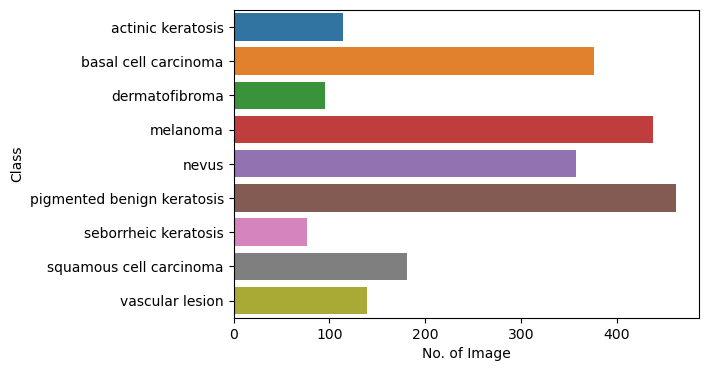

In [42]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.barplot(x="No. of Image", y="Class", data=count,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has least number of sample.
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis & melanoma


####  Rectifying the class imbalance
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
data_dir_train

WindowsPath('input/Skin cancer/Train')

In [91]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'\\'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to input\Skin cancer\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EAE02C4F40>: 100%|█| 500/500 [00:09<00:00, 54.95 Samples/


Initialised with 376 image(s) found.
Output directory set to input\Skin cancer\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EAB2A01780>: 100%|█| 500/500 [00:08<00:00, 56.44 Samples/


Initialised with 95 image(s) found.
Output directory set to input\Skin cancer\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EA83B6EF20>: 100%|█| 500/500 [00:08<00:00, 57.27 Samples/


Initialised with 438 image(s) found.
Output directory set to input\Skin cancer\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1EAB2B13310>: 100%|█| 500/500 [00:36<00:00, 13.65 Sample


Initialised with 357 image(s) found.
Output directory set to input\Skin cancer\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1EADF447760>: 100%|█| 500/500 [00:39<00:00, 12.71 Samples/


Initialised with 462 image(s) found.
Output directory set to input\Skin cancer\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EA81C99930>: 100%|█| 500/500 [00:08<00:00, 58.19 Samples/


Initialised with 77 image(s) found.
Output directory set to input\Skin cancer\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EA81CCA410>: 100%|█| 500/500 [00:19<00:00, 26.13 Samples


Initialised with 181 image(s) found.
Output directory set to input\Skin cancer\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EADF3920B0>: 100%|█| 500/500 [00:08<00:00, 61.82 Samples/


Initialised with 139 image(s) found.
Output directory set to input\Skin cancer\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EA83BD9A50>: 100%|█| 500/500 [00:08<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_392ba9d4-7160-46ae-8a2b-d746f0ee9ee3.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9edd1b4e-f415-4972-b6a6-d26156f7758f.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2489596f-340a-4bff-bda1-6282f6f03dec.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_8a1af03d-150a-4b56-9787-95bce62d8695.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_d1848fb5-2453-49ad-aa89-5981fa14b2e8.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_6c0a17b6-3336-4f86-b8fb-8190c0682440.jpg',
 'input\\Skin cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_7b969757-73af-4745-b9c7-83d3c88f156b.jpg',

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [62]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [69]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = count.append(df2)

In [70]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have extra 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [71]:
batch_size = 32
img_height = 180
img_width = 180

####  Creating a training dataset

In [73]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [75]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Modelling after treating class imbalance including nomalisation

In [81]:

num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### Compiling model 

In [82]:
## your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Training model

In [83]:
epochs = 30
## Your code goes here, use 30 epochs.
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 131s 762ms/step - loss: 1.7937 - accuracy: 0.3160 - val_loss: 1.4440 - val_accuracy: 0.4529
Epoch 2/30
169/169 [==============================] - 142s 836ms/step - loss: 1.4458 - accuracy: 0.4501 - val_loss: 1.3033 - val_accuracy: 0.5130
Epoch 3/30
169/169 [==============================] - 167s 986ms/step - loss: 1.3055 - accuracy: 0.5182 - val_loss: 1.2370 - val_accuracy: 0.5212
Epoch 4/30
169/169 [==============================] - 152s 895ms/step - loss: 1.1314 - accuracy: 0.5805 - val_loss: 1.1765 - val_accuracy: 0.5880
Epoch 5/30
169/169 [==============================] - 160s 941ms/step - loss: 0.9563 - accuracy: 0.6526 - val_loss: 0.9106 - val_accuracy: 0.6615
Epoch 6/30
169/169 [==============================] - 149s 878ms/step - loss: 0.7993 - accuracy: 0.7105 - val_loss: 0.8412 - val_accuracy: 0.6993
Epoch 7/30
169/169 [==============================] - 150s 885ms/step - loss: 0.6511 - accuracy: 0.7598 - val_loss: 0.9140 -

#### **Todo:**  Visualize the model results

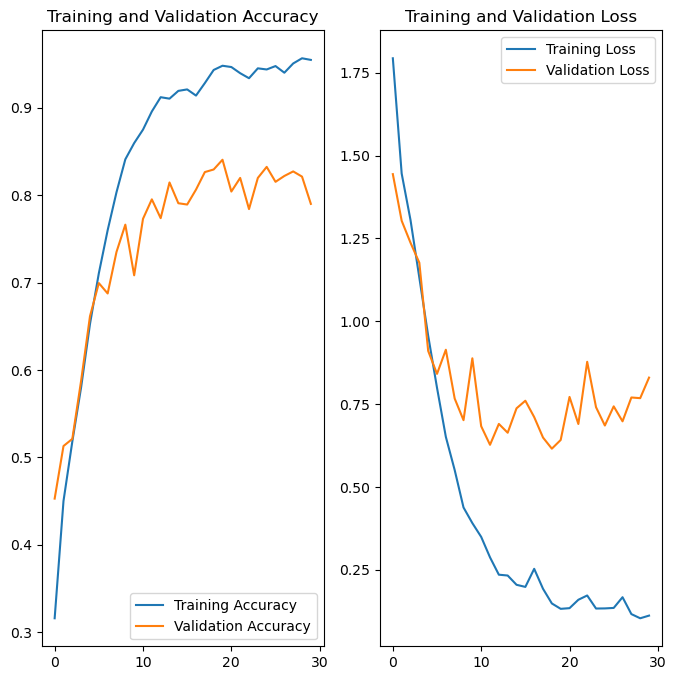

In [85]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?





The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.94 at 20 epochs, and validation accuracy at 0.84. Judging by the large fluctuations in the validation loss, we can rerun the training with a reducing learning rate. The model seems to be jumping around a local minimum.Possibly including a callback to reduce the learning rate once an accuracy of 0.8 has been reached may lead to improvements.



 - Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter